# Implementing  BVEP brain network model in Stan


In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import re
import glob
from itertools import chain
from operator import itemgetter

import json
import pickle

import scikitplot as skplt
from sklearn.metrics import confusion_matrix

# from scipy.optimize import fsolve
# from scipy.optimize import root

In [3]:
import pystan

from parse_csv import parse_csv2
from read_csvs import read_samples

from report_nodetype import node_EzPzHz_idex
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage
from report_nodetype import node_score_std_extrm, node_score_ezpz

In [4]:
import warnings
import yaml

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
yaml.warnings({'YAMLLoadWarning': False})

In [5]:
%pylab inline
#%matplotlib inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [6]:
def f_int(x):
    return np.int(x)

f_vector_int = np.vectorize(f_int)

In [7]:
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Syntetic Data

In [8]:
data_dir = 'data_input_files'
results_dir = 'data_output_files'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

In [9]:
cwd = os.getcwd()
print("The results directory is:", cwd)

The results directory is: /data/meysam/VepSyntheticData/BVEP-master


In [10]:
Mainpath =cwd+"/"

In [11]:
Reportmetrics_dir = os.path.join(cwd, Mainpath+"/data_output_files/figures/")

In [12]:
eta_true_inx, eta_true_mu, eta_true_sd = np.loadtxt(Mainpath+"ExperimentalData_CJ"+"/"+"eta_patient1"+".txt", delimiter=',', usecols=(0,1,2), skiprows=1, ).T 

In [13]:
with open(Mainpath+"ExperimentalData_CJ"+"/"+"true_labels_nodes_patient1"+".txt", 'r') as filehandle:  
          true_labels_nodes = json.load(filehandle)              

In [14]:
data_input = np.load(Mainpath+"data_input_files/"+"DatainputSLRawDecim84nodes_patient1.npz")

In [15]:
Obs = data_input['Obs']
#Obs2 = data_input['Obs2']
SC = data_input['SC']
tau0 = data_input['tau0']
Ks = data_input['Ks']
nodes=data_input['nodes']
num_nodes=data_input['nn']
ts = data_input['ts']

In [16]:
print('data shape:',Obs.shape)

data shape: (120, 84)


In [17]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

In [18]:
eta_ez= -1.6
eta_pz= -2.4
eta_hz= -3.65

In [19]:
Ez_indices, Pz_indices, Hz_indices, Ez_arr, Pz_arr, Hz_arr= node_EzPzHz_idex(true_labels_nodes)

In [20]:
print("Ez_indices:", Ez_indices)
print("Pz_indices:", Pz_indices)

Ez_indices: [6, 34]
Pz_indices: [5, 11, 27]


# Provisioning BVEP

## Observation

In [21]:
network = np.load(f'{data_dir}/DatainputSLRawDecim84nodes_patient1.R.npz')

In [22]:
xs = np.load(f'{data_dir}/DatainputSLRawDecim84nodes_patient1.R.npz')['Obs']

In [23]:
obs = dict()
obs['xs'] = xs

In [24]:
xs_pwr = (xs*xs).sum (axis=0)
xs_pwr = (xs_pwr/ xs_pwr.max())

In [25]:
obs['xs_pwr']=xs_pwr

In [26]:
eni_idx=np.argsort(obs['xs_pwr'])
eni_idx

array([ 6, 34, 27, 11,  5, 83,  9,  7, 29, 60, 20, 14, 13, 23, 16, 28, 54,
        3,  4, 19, 61, 39,  0, 78, 81, 72, 22, 57, 58, 38, 42, 52, 41, 36,
        1, 35, 76, 46, 80, 65, 53, 26, 51, 62, 12,  8, 10, 43, 47, 21, 45,
       66, 82, 33,  2, 75, 59, 79, 73, 68, 44, 69, 50, 17, 15, 32, 64, 55,
       71, 67, 40, 18, 25, 63, 24, 56, 70, 77, 37, 30, 31, 74, 48, 49])

In [27]:
obs['xs'].shape

(120, 84)

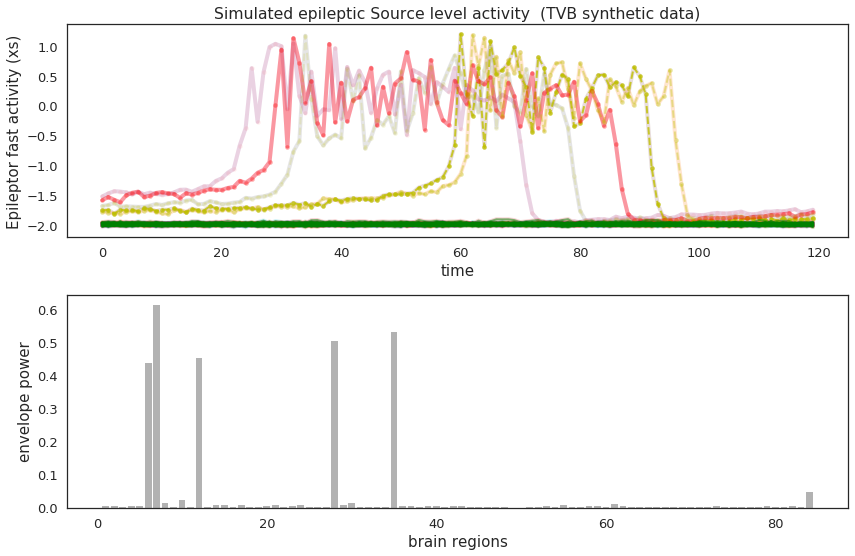

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(obs['xs'], linewidth=4, alpha=0.2);
for i in range(obs['xs'].shape[1]):
    if i in Ez_indices:
        plot(obs['xs'][:,i], linestyle='-', marker='.', linewidth=4, color='r', alpha=2./i)
    elif i in Pz_indices:
        plot(obs['xs'][:,i], linestyle='--', marker='.',linewidth=2, color='y', alpha=4./i)
    else: 
        plot(obs['xs'][:,i], linestyle='-', linewidth=2, color='g', alpha=0.5)
plt.xlabel('time', fontsize=15)
plt.ylabel('Epileptor fast activity (xs)', fontsize=15)
plt.title('Simulated epileptic Source level activity  (TVB synthetic data)')
plt.subplot(212)
plt.bar(np.arange(1,obs['xs_pwr'].shape[0]+1), 1.-obs['xs_pwr'], color='black', alpha=0.3)
plt.xlabel('brain regions', fontsize=15)
plt.ylabel('envelope power', fontsize=15)
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/figure_obsdata_patient1.png')
plt.show()

## NonCenterized form of parameterization

In [29]:
! cat BVEP_noncentered.stan

/* Written in INS Marseille*/
data {
    int nn; //number of brain regions
    int nt;  //number of data points per brain region
    real dt; //time step in Euler integration
    real tau0; //time scale in Eipleptor model
    real I1; //input current in in Eipleptor model
    real Ks; //global connectivity parameter
    real zlim[2]; 
    real xlim[2]; 
    matrix [nn, nn] SC; // brain structural connectivity
    matrix[nt, nn] Obs; //fast activity variable at source-level
}

transformed data {
    vector[2] initial_val;
    vector[nn*nt] xs;
    xs=to_vector(Obs); //vectorize observations
    initial_val[1]=-1.5; //initial condition of fast activity variable in Epileoptor
    initial_val[2]=+3.5; //initial condition of Epileoptor slow variable in Epileoptor
}

parameters {
    vector<lower=xlim[1], upper=xlim[2]>[nn] x_init;
    vector<lower=zlim[1], upper=zlim[2]>[nn] z_init;
    matrix[nn, nt-1] x_eta;
    matrix[nn, nt-1] z_eta;
    vector[nn] eta_star;
    real K_star;
    real<lo

In [30]:
model=str('BVEP_noncentered')

In [31]:
curr_dir=cwd

In [32]:
! cd /home/meysam/cmdstan && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  /data/meysam/VepSyntheticData/BVEP-master/BVEP_noncentered.stan --o=/data/meysam/VepSyntheticData/BVEP-master/BVEP_noncentered.hpp
Model name=BVEP_noncentered_model
Input file=/data/meysam/VepSyntheticData/BVEP-master/BVEP_noncentered.stan
Output file=/data/meysam/VepSyntheticData/BVEP-master/BVEP_noncentered.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -O3 -march=native -mtune=native -DNO_FPRINTF_OUTPUT -pipe    -O3 -o /data/meysam/VepSyntheticData/BVEP-master/BVEP_noncentered src/cmdstan/main.cpp -include /da

In [33]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=200
warm_iter=200

model=BVEP_noncentered
data_input=DatainputSLRawDecim84nodes_patient1.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [34]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [35]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/meysam/VepSyntheticData/BVEP-master/data_output_hmc_BVEP_noncentered'

In [36]:
! ls $dir_data_output

output_hmc_BVEP_noncentered_1.csv  output_hmc_BVEP_noncentered_3.csv
output_hmc_BVEP_noncentered_1.out  output_hmc_BVEP_noncentered_3.out
output_hmc_BVEP_noncentered_2.csv  output_hmc_BVEP_noncentered_4.csv
output_hmc_BVEP_noncentered_2.out  output_hmc_BVEP_noncentered_4.out


In [37]:
!tail -n2 $dir_data_output/*$model*out

==> /data/meysam/VepSyntheticData/BVEP-master/data_output_hmc_BVEP_noncentered/output_hmc_BVEP_noncentered_1.out <==
               21290.7 seconds (Total)


==> /data/meysam/VepSyntheticData/BVEP-master/data_output_hmc_BVEP_noncentered/output_hmc_BVEP_noncentered_2.out <==
               23152.4 seconds (Total)


==> /data/meysam/VepSyntheticData/BVEP-master/data_output_hmc_BVEP_noncentered/output_hmc_BVEP_noncentered_3.out <==
               23976.3 seconds (Total)


==> /data/meysam/VepSyntheticData/BVEP-master/data_output_hmc_BVEP_noncentered/output_hmc_BVEP_noncentered_4.out <==
               28662.1 seconds (Total)



## check the convergence 

In [38]:
chain=1

In [39]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_BVEP_noncentered_1.csv'

In [40]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.csv'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [41]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

Iteration: 400 / 400 [100%]  (Sampling)
  Elapsed Time: 10972.6 seconds (Warm-up)
                10318.1 seconds (Sampling)
                21290.7 seconds (Total)



In [42]:
from report_algconfigs import hmc_config
num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

In [43]:
num_samples=int(num_samples)

In [44]:
if int(save_warmup)==0:
    Burnin=0
nSample=num_samples-Burnin

## posterior predictive density 

In [45]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [46]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (200,)
accept_stat__ (200,)
stepsize__ (200,)
treedepth__ (200,)
n_leapfrog__ (200,)
divergent__ (200,)
energy__ (200,)
x_init (200, 84)
z_init (200, 84)
x_eta (200, 119, 84)
z_eta (200, 119, 84)
eta_star (200, 84)
K_star (200,)
amplitude_star (200,)
offset_star (200,)
eps (200,)
sig (200,)
eta (200, 84)
K (200,)
amplitude (200,)
offset (200,)
x (200, 120, 84)
z (200, 120, 84)
xhat_qqc (200, 10080)
x_ppc (200, 10080)
log_lik (200, 10080)
log_lik_sum (200, 120)
gx (200,)
dx (200,)
dz (200,)


In [47]:
x_nuts=fit['x'][-nSample:]
z_nuts=fit['z'][-nSample:]

In [48]:
x_nuts.shape, z_nuts.shape

((200, 120, 84), (200, 120, 84))

In [49]:
eta_est_nuts=fit['eta'][-nSample:]
Kest_nuts=fit['K'][-nSample:]
amplitude_nuts=fit['amplitude'][-nSample:]
offset_nuts=fit['offset'][-nSample:]
eps_nuts=fit['eps'][-nSample:]
sig_nuts=fit['sig'][-nSample:]

In [50]:
eta_est_nuts.shape, amplitude_nuts.shape, Kest_nuts.shape, sig_nuts.shape

((200, 84), (200,), (200,), (200,))

In [51]:
x_est_nuts, z_est_nuts, amplitude_est_nuts, offset_est_nuts = np.transpose(x_nuts, (0, 2, 1)),  np.transpose(z_nuts, (0, 2, 1)), amplitude_nuts.reshape((-1, 1, 1)),  offset_nuts.reshape((-1, 1, 1))
x_est_nuts.shape, amplitude_est_nuts.shape

((200, 84, 120), (200, 1, 1))

In [52]:
Obs_est_nuts =  amplitude_est_nuts*x_est_nuts + offset_est_nuts
Obs_est_nuts.shape

(200, 84, 120)

In [53]:
eta_est_mu_nuts=np.mean(eta_est_nuts, axis=0)
eta_est_std_nuts=np.std(eta_est_nuts, axis=0)

In [54]:
Obs_low_nuts, Obs_hi_nuts = percentile(Obs_est_nuts, [5, 95], axis=0)
LSE_val_nuts=LSE_obs(Obs.T, Obs_low_nuts, Obs_hi_nuts)
print('LSE_val_nuts=', LSE_val_nuts)

LSE_val_nuts= 57.758446715872054


In [55]:
err_eta_nuts=Err(eta_true_mu, eta_est_mu_nuts)
z_score_eta_nuts=np.sum(z_score(eta_true_mu, eta_est_mu_nuts, eta_est_std_nuts))
shrinkage_eta_nuts=np.mean(shrinkage([prior_std]*nodes.shape[0], eta_est_std_nuts))

In [56]:
score_std_nuts, score_extrm_nuts= node_score_std_extrm(nodes, eta_est_nuts, eta_true_mu, sd_thr)
score_ez_nuts, score_pz_nuts, ce_nuts, cp_nuts, nodes_est_nuts, est_labels_nodes_nuts= node_score_ezpz(nodes, eta_est_nuts, true_labels_nodes, eta_c, delta_eta, 1.)
print ('Prediction about Ez and Pz nodes is=', int(score_ez_nuts+score_pz_nuts),' out of', len(Ez_indices)+len(Pz_indices), ' EzPznodes')                                              

Prediction about Ez and Pz nodes is= 5  out of 5  EzPznodes


In [57]:
y_true=true_labels_nodes
y_pred_nuts=est_labels_nodes_nuts                                           
confusion_matrix_values_nuts= confusion_matrix(y_true, y_pred_nuts, labels=["EZ", "PZ", "HZ"])
accuracy_nuts=100*np.trace(confusion_matrix_values_nuts)/np.sum(confusion_matrix_values_nuts)
print ('Prediction about all the node types is=', int(np.trace(confusion_matrix_values_nuts)),' out of', len(nodes), ' nodes')

Prediction about all the node types is= 84  out of 84  nodes


In [58]:
showpicks = f_vector_int(np.r_[int(Hz_indices[0]), int(Pz_indices[0]), int(Ez_indices[0])])
showpicks=showpicks.tolist()
print("Shown nodes are:", [(x+1) for x in showpicks])

Shown nodes are: [1, 6, 7]


In [59]:
Obs.shape, Obs_est_nuts.shape, Obs_low_nuts.shape

((120, 84), (200, 84, 120), (84, 120))

In [60]:
from report_plots import plot_features, plot_zscore_shrinkage,  plot_posterior, ppplot, plot_obs_x, plot_obs_z, plot_hiddenstates_x, plot_hiddenstates_z, plot_confusion_matrix

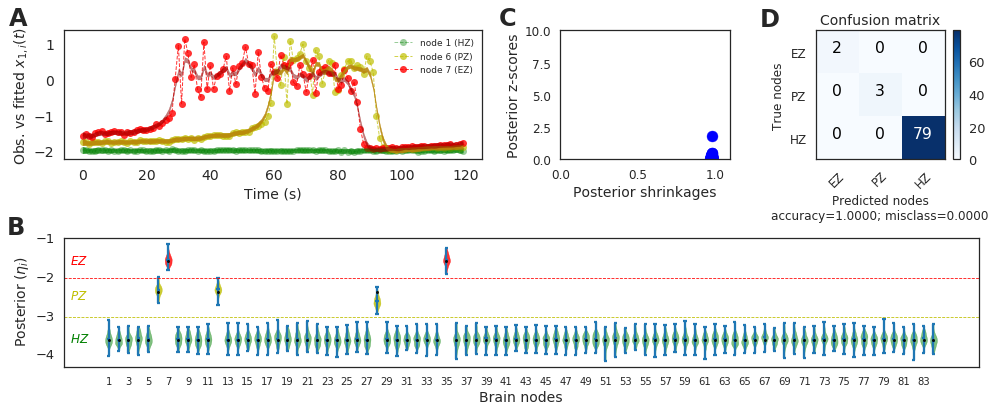

In [61]:
plt.figure(figsize=(14, 6))  
grid = plt.GridSpec(2, 4)  
plt.subplot(grid[0, :2]) 
plot_features(0.1*ts, Obs, np.transpose(Obs_est_nuts, (0, 2, 1)), showpicks)
plt.subplot(grid[0, 2]) 
plot_zscore_shrinkage(nodes, eta_true_mu, eta_est_mu_nuts, eta_est_std_nuts, prior_std)
plt.subplot(grid[0, 3]) 
plot_confusion_matrix(confusion_matrix_values_nuts, ["EZ", "PZ", "HZ"])
plt.subplot(grid[1, 0:])            
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), eta_est_nuts)
plt.savefig(os.path.join(Reportmetrics_dir,"figure_fit"+str(model)+"_chain_"+str(chain)+".png"), dpi=300)

plt.show()

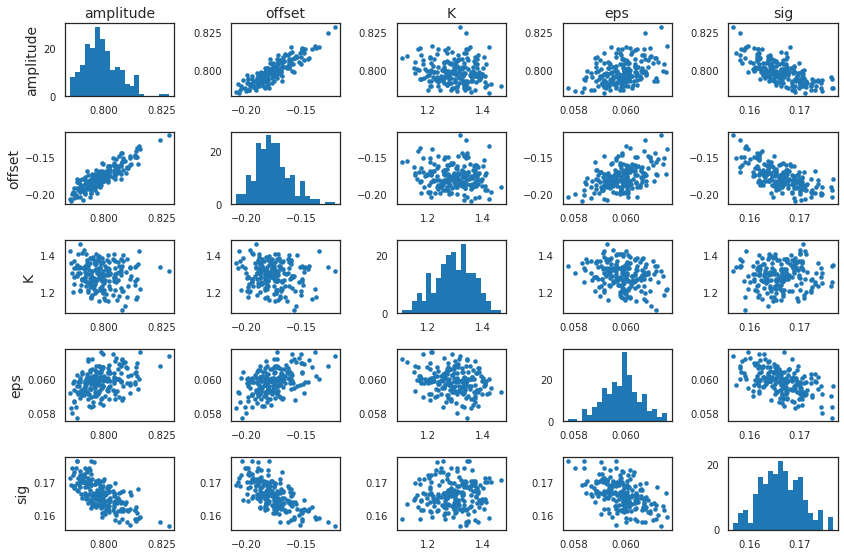

In [62]:
from report_plots import pair_plots_params
extras = ' amplitude offset K eps sig'.split()              
plt.figure(figsize=(12, 8)) 
pair_plots_params(fit, extras)  
plt.tight_layout()
plt.savefig(os.path.join(Reportmetrics_dir,"figure_pairplot"+str(model)+"_chain_"+str(chain)+".png"), dpi=300)
plt.show()

## Posterior convergence and diagnostics

In [63]:
divergent__=fit['divergent__'][-nSample:][:,newaxis]
stepsize__=fit['stepsize__'][-nSample:][:,newaxis]

lp__=fit['lp__'][-nSample:][:,newaxis]
accept_stat__=fit['accept_stat__'][-nSample:][:,newaxis]
energy__=fit['energy__'][-nSample:][:,newaxis]

treedepth__=fit['treedepth__'][-nSample:][:,newaxis]
n_leapfrog__=fit['n_leapfrog__'][-nSample:][:,newaxis]


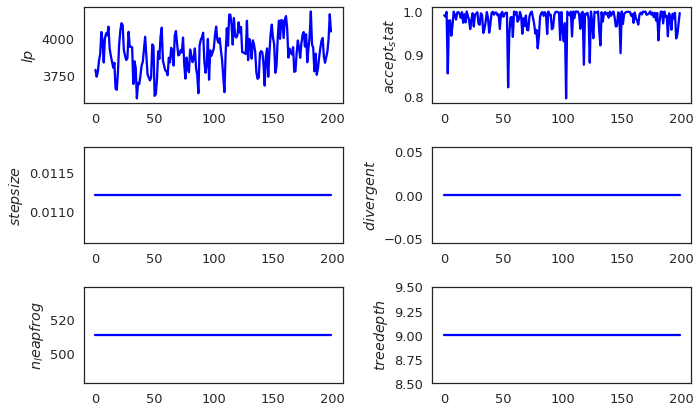

In [64]:
figure(figsize=(10, 6))

plt.subplot(321)
plt.plot(lp__, 'b')
plt.ylabel("$lp$")
plt.subplot(322)
plt.plot(accept_stat__, 'b')
plt.ylabel("$accept_stat$")

plt.subplot(323)
plt.plot(stepsize__, 'b')
plt.ylabel("$stepsize$")
plt.subplot(324)
plt.plot(divergent__, 'b')
plt.ylabel("$divergent$")

plt.subplot(325)
plt.plot(n_leapfrog__, 'b')
plt.ylabel("$n_leapfrog$")
plt.subplot(326)
plt.plot(treedepth__, 'b')
plt.ylabel("$treedepth$")

tight_layout()
plt.show()

In [65]:
from  report_diagnostics_stan import  run_summary, Nuts_plot, check_rhat, check_div, check_treedepth, check_energy, check_n_eff


In [66]:
dict_samples_diagnostics=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=num_samples,  variables_of_interest=['lp__', 'energy__', 'accept_stat__', 'divergent__', 'treedepth__', 'n_leapfrog__'  ])


In [67]:
lp__, accept_stat__, treedepth__, divergent__, energy__,  = dict_samples_diagnostics['lp__'], dict_samples_diagnostics['accept_stat__'],  dict_samples_diagnostics['treedepth__'], dict_samples_diagnostics['divergent__'], dict_samples_diagnostics['energy__']


In [68]:
check_divergence__=check_div(divergent__)
check_treedepth__=check_treedepth(treedepth__, int(max_depth))
check_energy__=check_energy(energy__)

In [69]:
check_divergence__, check_treedepth__, check_energy__

(0.0, 0.0, 0.7647142184365703)

In [70]:
fit_summary=run_summary(cwd+"/", dir_data_output+"/"+str(fit_filename_csv))

fit_filefoder: data_output_hmc_BVEP_noncentered
fit_filename: output_hmc_BVEP_noncentered_1.csv
mycsvfile: /data/meysam/VepSyntheticData/BVEP-master/data_output_hmc_BVEP_noncentered/output_hmc_BVEP_noncentered_1.csv
running stan summary!
finished stan summary!


In [71]:
cd ..


/data/meysam/VepSyntheticData/BVEP-master


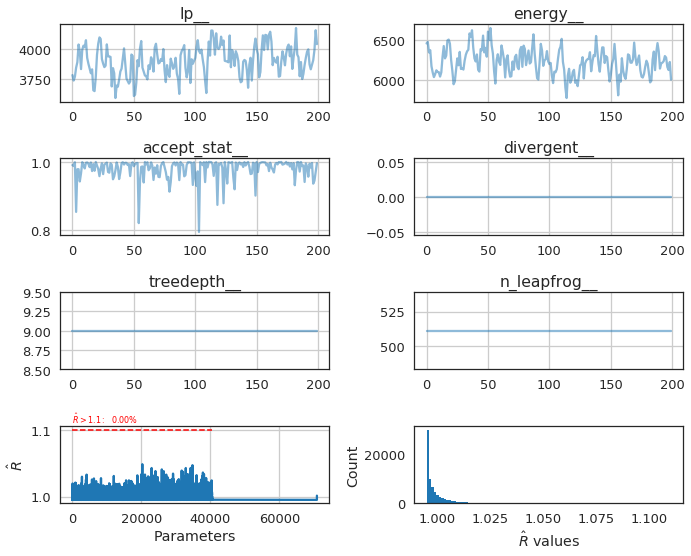

In [72]:
plt.figure(figsize=(10,8))
Nuts_plot(dict_samples_diagnostics, fit_summary)
plt.tight_layout()
plt.savefig(os.path.join(Reportmetrics_dir,"figure_nuts_diagnostics_"+str(model)+"_chain_"+str(chain)+".png"), dpi=300)
plt.show()